# Requesting Calendar Events from MS Graph API
This notebook will demonstrate the steps necessary to retrieve calendar events
from a designated outlook calendar by making HTTP requests to the API.
Application registration through Azure Portal is a pre-requisite to calling the API. 

In [165]:
import json
import requests
import datetime as dt
from datetime import timedelta
from dateutil import parser
import pytz
import config as cfg
import os
import pandas as pd
import numpy as np

### Obtaining an Authorization Token
Authorization Tokens are issued upon verified authentication.
I am using the "username/password" method of authentication.
In an attempt to simplify this demonstration,
I will be saving my token details in a json file.
This file will check the expiration date before issuing a new token.

In [36]:
def acquire_token():
    if 'access-token.json' in os.listdir():
        file_path = os.getcwd() + '\\access-token.json'
        f = open(file_path)
        data = json.load(f)
        f.close()
        now = pytz.utc.localize(dt.datetime.now())
        exp_date = dt.datetime.fromtimestamp(int(data['expires_on']))
        exp_date = pytz.utc.localize(exp_date)
        if now > exp_date:
            token_request = requests.post(
                cfg.token_URL, 
                cfg.token_body
                )
            res = json.loads(token_request.text)
            access_token = res['access_token']
            with open(file_path, 'w') as jf:
                json.dump(res, jf, indent=4)
                jf.close()
        else:
            access_token = data['access_token']
    else:
        file_path = os.getcwd() + '\\access-token.json'
        token_request = requests.post(
            cfg.token_URL, 
            cfg.token_body
            )
        res = json.loads(token_request.text)
        access_token = res['access_token']
        with open(file_path, 'w') as jf:
            json.dump(res, jf, indent=4)
            jf.close()
    return access_token

#### Notes on above function
When acquire_token() is called, the current working directoy will be checked for a json file storing token details. If that file exists, the expiration date of the access token will be checked against the current DateTime. An expired token will result in the issuing of a new token, whereas non-expired tokens simply result in a returned access token value from the json file. Should the file be missing from the directory, a new request will be made and the resulting token details will be saved to a new file named access-token.json. This file can then be used for future call to the function.

In [497]:
# Assign our returned value from function call to variable named access_token

access_token = acquire_token()

In [498]:
access_token

'eyJ0eXAiOiJKV1QiLCJub25jZSI6IjkzVlBsSE1FMUcxRW1URnlxT3pfcWJ2Zm9vT2stYVIwNk04b0I2MzlqODQiLCJhbGciOiJSUzI1NiIsIng1dCI6ImpTMVhvMU9XRGpfNTJ2YndHTmd2UU8yVnpNYyIsImtpZCI6ImpTMVhvMU9XRGpfNTJ2YndHTmd2UU8yVnpNYyJ9.eyJhdWQiOiJodHRwczovL2dyYXBoLm1pY3Jvc29mdC5jb20iLCJpc3MiOiJodHRwczovL3N0cy53aW5kb3dzLm5ldC9iMDJkYTY1NS0wMTliLTQyODItOTQ5MC01MzBlZDkxNTNmYzgvIiwiaWF0IjoxNjUwNTU2NTg3LCJuYmYiOjE2NTA1NTY1ODcsImV4cCI6MTY1MDU2MTkwMCwiYWNjdCI6MCwiYWNyIjoiMSIsImFpbyI6IkUyWmdZTEM0YzR4cmdxdjJ1a3pXSDRmYmZ2V0dWSzB0K1hiODJaSmVsNnNWSEVLSFZjTUIiLCJhbXIiOlsicHdkIl0sImFwcF9kaXNwbGF5bmFtZSI6IkNhbGVuZGFyIFN5bmMiLCJhcHBpZCI6Ijc0NWZkMTQ3LTQ4YjktNGU1ZS05NGEyLWUzZDU5MWEyNjYwYyIsImFwcGlkYWNyIjoiMSIsImZhbWlseV9uYW1lIjoiTG9kaXNoIiwiZ2l2ZW5fbmFtZSI6IkF1c3RpbiIsImlkdHlwIjoidXNlciIsImlwYWRkciI6IjE3NC4xMTEuNDguMTc5IiwibmFtZSI6IkF1c3RpbiBMb2Rpc2giLCJvaWQiOiIyYWRmODcxZC00ZjQwLTRlODMtOThmMi1kNmU0ZWEwNzMxM2IiLCJvbnByZW1fc2lkIjoiUy0xLTUtMjEtNTc5ODk4NDEtMjAyNTQyOTI2NS02ODIwMDMzMzAtODAwNiIsInBsYXRmIjoiMTQiLCJwdWlkIjoiMTAwMzIwMDFENDE5Rk

### The resulting json file containing token details
Notice expiration is a timestamp string. Tokens are valid for ~90 minutes.

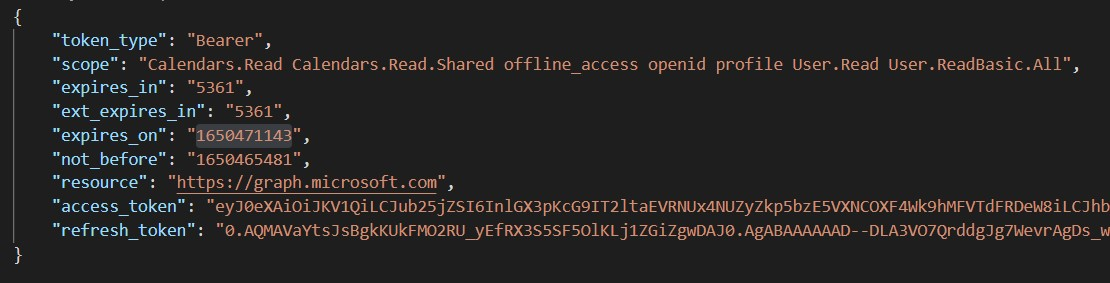

### Access Token Granted
Now that we have a valid access token, we can begin querying the Graph API.

### Finding Calendar IDs
Calendar IDs for a user can be obtained by making a GET request to https://graph.microsoft.com/v1.0/me/calendars

In [499]:
headers = {
    'authorization': 'Bearer ' + access_token,
    'content-type': 'application/json'
}

In [51]:
# Find our calendar and store the ID in config file
get_cals_url = 'https://graph.microsoft.com/v1.0/me/calendars'
cal_id = requests.get(get_cals_url, headers=headers)
cal_data = json.loads(cal_id.text)
all_cals = cal_data['value']
len(all_cals)

4

**Here we can see I have four unique calendars. Let's check their names and IDs.**

In [59]:
for i in range(len(all_cals)):
    print('Calendar', i)
    print('Name:', all_cals[i]['name'])
    print('Calendar ID:', all_cals[i]['id'][60:-1], '\n')

Calendar 0
Name: Calendar
Calendar ID: AybkQFt2TaRAuNzw7ipf3TkHAJ_RS9cXafJDkBzmuaaOT9QAAAIBBgAAAJ_RS9cXafJDkBzmuaaOT9QAAAJnIQAAAA= 

Calendar 1
Name: United States holidays
Calendar ID: AAAm5EBbdk2kQLjc8O4qX905BwCfkUvXF2nyQ5Ac5rmmjk-UAAAAAAEGAACfkUvXF2nyQ5Ac5rmmjk-UAAAC-P55AAA 

Calendar 2
Name: Birthdays
Calendar ID: AAAm5EBbdk2kQLjc8O4qX905BwCfkUvXF2nyQ5Ac5rmmjk-UAAAAAAEGAACfkUvXF2nyQ5Ac5rmmjk-UAAAC-P57AAA 

Calendar 3
Name: test
Calendar ID: AAAm5EBbdk2kQLjc8O4qX905BwCfkUvXF2nyQ5Ac5rmmjk-UAAAAAAEGAACfkUvXF2nyQ5Ac5rmmjk-UAAAC_2WgAAA 



### Requesting Events from Desired Calendar
I will be using the 'test' calendar for this demonstration. I've saved the ID to my config file which I will use to format my request URL. Calendar 0 will always be the default calendar should the ID be left out of the request URL.

In [130]:
# Obtain our request URL from config and format it with the ID of our desired calendar

url = cfg.get_all_events.format(calendar_id=cfg.test_calendar)
events = requests.get(url, headers=headers)

In [451]:
# Load our response, 'events', into json object

events_data = json.loads(events.text)
len(events_data['value'])

10

### The reqeust only responded with 10 events, but I am sure I have 12.
This is due to MS Graph's default response limit of 10 results per page. The response will include an indicator that more events exist. To retrieve the next page of events, use the URL value from @odata.nextLink to make another request. Continue this process until the response no longer contains the key @odata.nextLink.   

In [452]:
next_key = '@odata.nextLink'
next_url = events_data[next_key]
next_url

"https://graph.microsoft.com/v1.0/me/calendars('AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMjQ1NTdiYwBGAAAAAAAm5EBbdk2kQLjc8O4qX905BwCfkUvXF2nyQ5Ac5rmmjk-UAAAAAAEGAACfkUvXF2nyQ5Ac5rmmjk-UAAAC_2WgAAA=')/events?%24top=10&%24skip=10"

In [450]:
def clean_events(events_data):
    all_events = {}
    for i in range(len(events_data['value'])):
        all_events["event"+str(i)] = events_data['value'][i]
    return all_events

def clean_next(all_events, events_data):
    idx = len(all_events)
    while True:
        res = requests.get(events_data[next_key], headers=headers)
        res_data = json.loads(res.text)
        for i in range(len(res_data['value'])):
            all_events['event'+str(i + idx)] = res_data['value'][i]
        if next_key not in res_data:
            break
    return all_events

In [453]:
all_events = clean_events(events_data)

In [454]:
all_events = page_requests(all_events, events_data)

In [455]:
all_events.keys()

dict_keys(['event0', 'event1', 'event2', 'event3', 'event4', 'event5', 'event6', 'event7', 'event8', 'event9', 'event10', 'event11'])

### We've successfully retrieved all of the events from our calendar.
Now we need to clean up our results. Let's take a look at all of the keys for event0

In [456]:
for k in all_events['event0'].keys():
    print(k)

@odata.etag
id
createdDateTime
lastModifiedDateTime
changeKey
categories
transactionId
originalStartTimeZone
originalEndTimeZone
iCalUId
reminderMinutesBeforeStart
isReminderOn
hasAttachments
subject
bodyPreview
importance
sensitivity
isAllDay
isCancelled
isOrganizer
responseRequested
seriesMasterId
showAs
type
webLink
onlineMeetingUrl
isOnlineMeeting
onlineMeetingProvider
allowNewTimeProposals
occurrenceId
isDraft
hideAttendees
responseStatus
body
start
end
location
locations
recurrence
attendees
organizer
onlineMeeting
calendar@odata.associationLink
calendar@odata.navigationLink


I am most interested in **id**, **lastModifiedDateTime**, **subject**, **recurrence**, **start**, **end**, and **type**. Jupyter Notebooks display Pandas data frames beautifully, so I will prepare these data accordingly.

In [614]:
df_dict = {
    'id': [],
    'lastModifiedDateTime': [],
    'subject': [],
    'recurrence': [],
    'start': [],
    'end': [],
    'type': []
}

columns = [
    'id', 
    'lastModifiedDateTime',
    'subject', 
    'recurrence', 
    'start', 
    'end', 
    'type'
]

for event in all_events:
    for col in columns:
        if col in ['start', 'end']:
            df_dict[col].append(all_events[event][col]['dateTime'])
        else:
            df_dict[col].append(all_events[event][col])
        

In [615]:
df.head()

,id,lastModifiedDateTime,subject,recurrence,start,end,type
0,AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMj...,2022-04-20T16:37:02.5346236Z,event008,None,2022-05-25T12:00:00.0000000,2022-05-25T12:30:00.0000000,singleInstance
1,AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMj...,2022-04-20T16:37:02.4252355Z,event007,None,2022-05-19T12:00:00.0000000,2022-05-19T12:30:00.0000000,singleInstance
2,AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMj...,2022-04-20T16:36:44.7708255Z,event006,None,2022-05-17T12:00:00.0000000,2022-05-17T12:30:00.0000000,singleInstance
3,AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMj...,2022-04-20T16:36:44.6519655Z,event005,None,2022-05-05T12:00:00.0000000,2022-05-05T12:30:00.0000000,singleInstance
4,AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMj...,2022-04-20T16:36:25.8460953Z,event004,None,2022-05-04T12:00:00.0000000,2022-05-04T12:30:00.0000000,singleInstance


### Recursive Event Filtering
Notice the recurrence column. Events with None as the value are unique events. Those with a dictionary are recurrent events. We need to handle them differently than one-off events. Let's filter them out now.

In [464]:
non_recurrent_df = df.loc[df['recurrence'].isin([None])]

In [465]:
recurrent_df = df.loc[~df['recurrence'].isin([None])]

In [466]:
non_recurrent_df.head()

,id,lastModifiedDateTime,subject,recurrence,start,end,type
0,AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMj...,2022-04-20T16:37:02.5346236Z,event008,None,2022-05-25T12:00:00.0000000,2022-05-25T12:30:00.0000000,singleInstance
1,AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMj...,2022-04-20T16:37:02.4252355Z,event007,None,2022-05-19T12:00:00.0000000,2022-05-19T12:30:00.0000000,singleInstance
2,AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMj...,2022-04-20T16:36:44.7708255Z,event006,None,2022-05-17T12:00:00.0000000,2022-05-17T12:30:00.0000000,singleInstance
3,AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMj...,2022-04-20T16:36:44.6519655Z,event005,None,2022-05-05T12:00:00.0000000,2022-05-05T12:30:00.0000000,singleInstance
4,AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMj...,2022-04-20T16:36:25.8460953Z,event004,None,2022-05-04T12:00:00.0000000,2022-05-04T12:30:00.0000000,singleInstance


In [470]:
recurrent_df = recurrent_df.reset_index(drop=True)
recurrent_df

,id,lastModifiedDateTime,subject,recurrence,start,end,type
0,AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMj...,2022-04-06T17:16:45.2717043Z,monthly test,"{'pattern': {'type': 'relativeMonthly', 'inter...",2022-04-04T16:30:00.0000000,2022-04-04T17:00:00.0000000,seriesMaster
1,AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMj...,2022-04-19T20:23:25.237Z,test no exceptions,"{'pattern': {'type': 'weekly', 'interval': 1, ...",2022-04-04T15:30:00.0000000,2022-04-04T16:00:00.0000000,seriesMaster
2,AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMj...,2022-04-19T20:23:09.443Z,test,"{'pattern': {'type': 'weekly', 'interval': 1, ...",2022-04-29T14:30:00.0000000,2022-04-29T15:00:00.0000000,seriesMaster


In [468]:
recurrent_dict = recurrent_df.to_dict('records')

### Yes, back to a dictionary.
Pandas DataFrames are nice for viewing, but we need a bit more clean up. This could be done from the DataFrame object, but working with a dictionary should be more straightforward.

#### As for clean up
We really only need the ID and recurrence details, but I've included the subject as well. Will once again be querying the API in order to retrieve all of the recurring events for each seriesMaster. 

In [412]:
r_dict = {}
options = ['id', 'subject', 'recurrence']
for i in range(len(recurrent_dict)):
    for event in recurrent_dict[i]:
        if event in options:
            if type(recurrent_dict[i][event]) != dict:
                if event in r_dict:
                    r_dict[event].append(recurrent_dict[i][event])
                else:
                    r_dict[event] = [recurrent_dict[i][event]]
            else:
                for k, v in recurrent_dict[i][event]['pattern'].items():
                    if k in r_dict:
                        r_dict[k].append(v)
                    else:
                        r_dict[k] = [v]

In [413]:
r_df = pd.DataFrame.from_dict(r_dict)

In [414]:
r_df

,id,subject,type,interval,month,dayOfMonth,daysOfWeek,firstDayOfWeek,index
0,AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMj...,monthly test,relativeMonthly,1,0,0,[monday],sunday,first
1,AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMj...,test no exceptions,weekly,1,0,0,[monday],sunday,first
2,AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMj...,test,weekly,1,0,0,[friday],sunday,first


### Now we have a DataFrame with the details of our recurrent events
The next step is to query the API with each of the IDs. If all goes well, the response should contain all instances of the recurrent events. The response should even include information regarding events that are exceptions to the series pattern.

In [361]:
r_list = r_df['id'].tolist()
r_list

['AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMjQ1NTdiYwBGAAAAAAAm5EBbdk2kQLjc8O4qX905BwCfkUvXF2nyQ5Ac5rmmjk-UAAAC_2OjAACfkUvXF2nyQ5Ac5rmmjk-UAAAC_4OQAAA=',
 'AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMjQ1NTdiYwBGAAAAAAAm5EBbdk2kQLjc8O4qX905BwCfkUvXF2nyQ5Ac5rmmjk-UAAAC_2OjAACfkUvXF2nyQ5Ac5rmmjk-UAAAC_4OPAAA=',
 'AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMjQ1NTdiYwBGAAAAAAAm5EBbdk2kQLjc8O4qX905BwCfkUvXF2nyQ5Ac5rmmjk-UAAAC_2OjAACfkUvXF2nyQ5Ac5rmmjk-UAAAC_4OOAAA=']

### Now we need to iterate through each recursive event
This is essentially the same process that we performed earlier. The difference being we have a list of events. So we will start by making the request for the event instances for the first ID in our list. If the response contains a nextLink key, we will continue making requests until that key is missing from the response. Then we rinse and repeat for the following event ID. 

In [576]:
start = '2022-04-20T00:00:00.0000000'
end = '2025-04-20T00:00:00.0000000'
rec_events = {}
for i in range(len(r_list)):
    k = 0
    url = cfg.get_all_events.format(calendar_id=cfg.test_calendar)
    url += '/' + r_list[i] + '/instances?startDateTime={start}&endDateTime={end}&$count=true'
    url = url.format(start=start, end=end)
    req = requests.get(url, headers=headers)
    res = json.loads(req.text)
    for ii in range(len(res['value'])):
        sub = res['value'][ii]['subject']
        rec_events[sub + ' ' + str(k)] = res['value'][ii]
        k += 1
        if next_key in res:
            next_page = True
            next_url = res[next_key]
            while next_page:
                next_req = requests.get(next_url, headers=headers)
                next_res = json.loads(next_req.text)
                for j in range(len(next_res['value'])):
                    rec_events[sub + ' ' + str(k)] = next_res['value'][j]
                    k += 1
                if next_key in next_res:
                    next_url = next_res[next_key]
                else: 
                    next_page = False

In [617]:
len(rec_events)

280

### Now we have our recurring calendar events for the year
Let's do a quick reality check

#### First get all the unique keys from our recursive events dictionary
Then we will count the number of occurences for each event. Because we are pulling calendar events for the next three years, we should expect ~120 weekly events and ~30 monthly events.

In [603]:
all_keys = [k for k in rec_events.keys()]
unique_keys = []
all_just_text = []
for k in all_keys:
    just_text = k.replace(k.split(' ')[-1], '')[:-1]
    all_just_text.append(just_text)
    if just_text not in unique_keys:
        unique_keys.append(just_text)
counts = [print(i, all_just_text.count(i), sep=': ') for i in unique_keys]

monthly test: 30
test no exceptions: 130
test: 120


#### The results met our expectations
Now we can put them into a data frame for better viewing

In [624]:
df_dict = {
    'id': [],
    'lastModifiedDateTime': [],
    'subject': [],
    'start': [],
    'end': [],
    'type': []
}

columns = [
    'id', 
    'lastModifiedDateTime',
    'subject', 
    'start', 
    'end', 
    'type'
]

for event in rec_events:
    for col in columns:
        if col in ['start', 'end']:
            df_dict[col].append(rec_events[event][col]['dateTime'])
        else:
            df_dict[col].append(rec_events[event][col]) 

In [626]:
df_dict = pd.DataFrame.from_dict(df_dict)

# Final Results

In [629]:
df_dict.head(20)

,id,lastModifiedDateTime,subject,start,end,type
0,AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMj...,2022-04-06T17:16:45.2717043Z,monthly test,2022-05-02T16:30:00.0000000,2022-05-02T17:00:00.0000000,occurrence
1,AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMj...,2022-04-06T17:16:45.2717043Z,monthly test,2023-03-06T17:30:00.0000000,2023-03-06T18:00:00.0000000,occurrence
2,AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMj...,2022-04-06T17:16:45.2717043Z,monthly test,2023-04-03T16:30:00.0000000,2023-04-03T17:00:00.0000000,occurrence
3,AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMj...,2022-04-06T17:16:45.2717043Z,monthly test,2022-06-06T16:30:00.0000000,2022-06-06T17:00:00.0000000,occurrence
4,AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMj...,2022-04-06T17:16:45.2717043Z,monthly test,2023-03-06T17:30:00.0000000,2023-03-06T18:00:00.0000000,occurrence
5,AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMj...,2022-04-06T17:16:45.2717043Z,monthly test,2023-04-03T16:30:00.0000000,2023-04-03T17:00:00.0000000,occurrence
6,AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMj...,2022-04-06T17:16:45.2717043Z,monthly test,2022-07-04T16:30:00.0000000,2022-07-04T17:00:00.0000000,occurrence
7,AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMj...,2022-04-06T17:16:45.2717043Z,monthly test,2023-03-06T17:30:00.0000000,2023-03-06T18:00:00.0000000,occurrence
8,AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMj...,2022-04-06T17:16:45.2717043Z,monthly test,2023-04-03T16:30:00.0000000,2023-04-03T17:00:00.0000000,occurrence
9,AAMkADEyYTAyY2YzLTI5NTAtNDI5Ni04NWQ2LWMxZWQzMj...,2022-04-06T17:16:45.2717043Z,monthly test,2022-08-01T16:30:00.0000000,2022-08-01T17:00:00.0000000,occurrence


### Closing Thoughts
The purpose of this demonstration was to show some of the possibilities when requesting event data from the MS Graph API. Understanding the way events and event series are handled is useful and this knowledge will be utilized in order to make sense of change notification responses in the next stage of this project.